# **First** autoencoder

## Importing data

In [42]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
from sklearn.decomposition import PCA

from DATA_generator import *

%matplotlib inline
import matplotlib.pyplot as plt

#using lorenzos code from R
#import rpy2.robjects as robjects
#from rpy2.robjects import pandas2ri

Real DATA

In [2]:
bigData = pd.read_csv("/Users/salati/Documents/CODE/AE2/DATA/Muscle_exon.txt", sep=" ")
#Taking only the rythmic genes
PeriodicData=bigData.loc[["ENSG00000105516", "ENSG00000049246", "ENSG00000167074", "ENSG00000174738", "ENSG00000179094", "ENSG00000132326" , "ENSG00000170485", "ENSG00000133794","ENSG00000126368","ENSG00000008405","ENSG00000121671","ENSG00000159208"]]
DATA=torch.tensor(PeriodicData.values)
DATA=DATA.float()
E=np.array(PeriodicData.values)

true_phases=pd.read_csv("/Users/salati/Documents/CODE/AE2/DATA/true_phi.txt",sep=" ")
true_phases=np.array(true_phases.values)
true_phases=true_phases[:,0]

Simulated DATA

N_Samples=56
N_PeriodicGenes=12
N_NonPeriodicGenes=0
N_Genes=N_PeriodicGenes+N_NonPeriodicGenes
NoiseSigma=0.04

#E , true_phases, alpha=NonUniformDataGenerator(N_Samples=N_Samples, N_PeriodicGenes=N_PeriodicGenes,noise=True, N_NonPeriodicGenes=N_NonPeriodicGenes )
E , true_phases, alpha=DataGenerator(N_Samples=N_Samples, N_PeriodicGenes=N_PeriodicGenes,noise=True, N_NonPeriodicGenes=N_NonPeriodicGenes , Means=False, NoiseSigma=NoiseSigma )

DATA=torch.from_numpy(E)
DATA=DATA.float()

In [3]:
N_Genes=DATA.shape[0]
N_Samples=DATA.shape[1]
N_Samples

57

Select gene you are interested setting varaible g in order to plot data, and supposed distribution

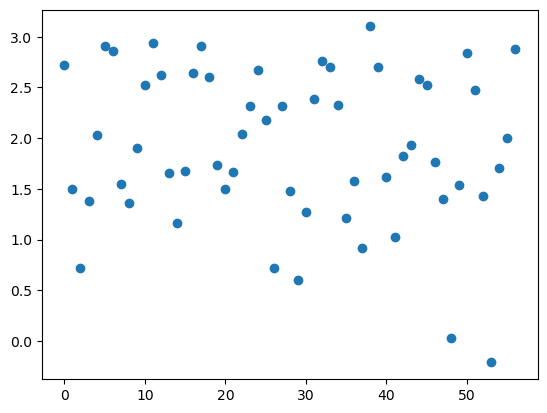

In [4]:
plt.plot(DATA[1,:], 'o')

## PCA

In [5]:
Et=np.transpose(E)
pca=PCA(n_components=2)
pca.fit(Et)

PCA(n_components=2)

In [6]:
pca.explained_variance_ratio_
PCA_base=pca.components_
PCA_base=np.array(PCA_base)
print('The two vectors are orthogonal, the scalar priduct is: ',np.matmul(PCA_base[0,:] ,PCA_base[1,:]) )


The two vectors are orthogonal, the scalar priduct is:  3.469446951953614e-17


In [7]:
pca_points=pca.fit_transform(Et)

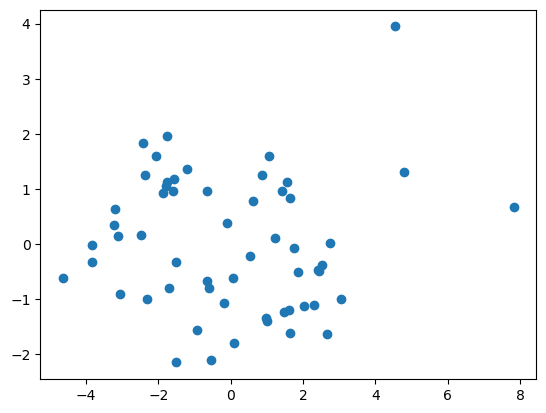

In [8]:
plt.plot(pca_points[:,0] , pca_points[:,1], 'o')

In [9]:
from DATA_generator import *
PCA_phi=np.arctan2(pca_points[:,0],pca_points[:,1])
PCAshifted_phi,madPCA=optimal_shift(PCA_phi, true_phases)
madPCA

0.33878580216853926

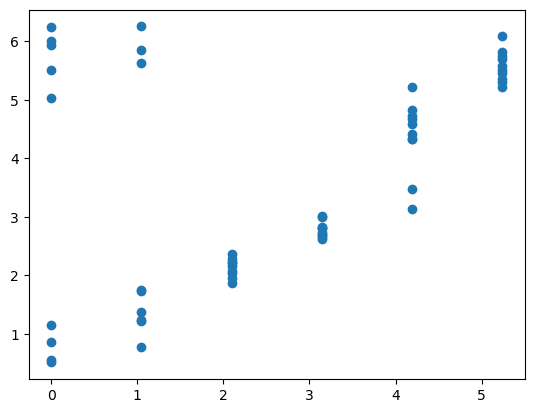

In [10]:
plt.plot(true_phases,PCAshifted_phi, 'o')

## Torch Linear

### Setting the network

In [11]:
PCA_tensor=torch.tensor(PCA_base)
PCA_tensor=PCA_tensor.float()
PCA_tensor

tensor([[-0.3415, -0.2836, -0.3255, -0.2395, -0.4008, -0.2304,  0.0701,  0.2681,
         -0.2792,  0.0499, -0.1431, -0.4982],
        [ 0.0096,  0.1267,  0.0540, -0.1128,  0.0749, -0.0783, -0.4529, -0.3995,
         -0.7616, -0.0944,  0.0129,  0.0511]])

In [12]:
class LinearEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(N_Genes, 2,bias=False)
        #self.encoder.weight=nn.Parameter(PCA_tensor)

        self.decoder = nn.Linear(2, N_Genes,bias=False)
        #self.decoder.weight=nn.Parameter(PCA_tensor.transpose(0,1))
           
    #fucntion that makes the input flow in the network
    def forward(self, x):
        encoded=self.encoder(x) #compress the input
        decoded=self.decoder(encoded)

        return decoded

In [60]:
#defining by hand and random initializing the weights
encoder_w=torch.randn((2, N_Genes), requires_grad=True)
decoder_w=torch.randn((N_Genes, 2), requires_grad=True)

encoder_w

tensor([[ 0.5809,  1.2599,  1.3183, -0.3369,  0.5795, -1.7010,  0.6633, -1.7482,
         -0.9172, -0.3871,  1.2630,  0.1999],
        [-0.3026,  0.4238, -0.2995,  0.7229,  1.7994, -1.9065,  0.0350, -0.6708,
          0.7627,  0.0342,  1.4724, -0.0229]], requires_grad=True)

Here I create an instance of the class LinearEncoder and define other important stuff like the loss function

In [13]:
criterion= nn.MSELoss()
#optimizer = torch.optim.SGD(model.parameters(),lr=0.00001)
optimizer=torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


Adding the GPU stuff

In [14]:
#for GPU use this block

#device = torch.device('mps')
#E_t=torch.from_numpy(E)
#E_t=E_t.float()
#DATA=torch.tensor(E_t,  device=device)
#model.to(device)


# for CPU keep this line

Training cycle

In [65]:
#recon= reconstruction of the input
num_epochs=10
outputs=[]

for epoch in range(num_epochs):
 
  for sample in range(N_Samples):
    input=DATA[:,sample]
    #print("input ",input.shape)
    hidden=F.linear( input, encoder_w)
    #print("hidden ",hidden)
    recon=F.linear( hidden, decoder_w)
    #print('recon ' ,recon)
    loss=criterion(recon,input)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #added this line to compare with the circular model, thisline block the convergence
  if loss.item() < 0.0005 :
    break
  if (epoch % 1 ==0):
    print("epoch ",epoch,"Loss", loss.item())

epoch  0 Loss 182.4097900390625
epoch  1 Loss 182.4097900390625
epoch  2 Loss 182.4097900390625
epoch  3 Loss 182.4097900390625
epoch  4 Loss 182.4097900390625
epoch  5 Loss 182.4097900390625
epoch  6 Loss 182.4097900390625
epoch  7 Loss 182.4097900390625
epoch  8 Loss 182.4097900390625
epoch  9 Loss 182.4097900390625


In [18]:
NNphases=np.zeros((N_Samples,2))
for sample in range(N_Samples):
  temp=torch.matmul(encoder_base, DATA[:,sample]).detach().numpy()
  NNphases[sample,:]=temp

with torch.no_grad():
    for X, y in test_dataloader:
        outputs = model(X)
        predicted = np.where(outputs < 0.5, 0, 1)
        predicted = list(itertools.chain(*predicted))
        y_pred.append(predicted)
        y_test.append(y)
        total += y.size(0)
        correct += (predicted == y.numpy()).sum().item()

### Plots

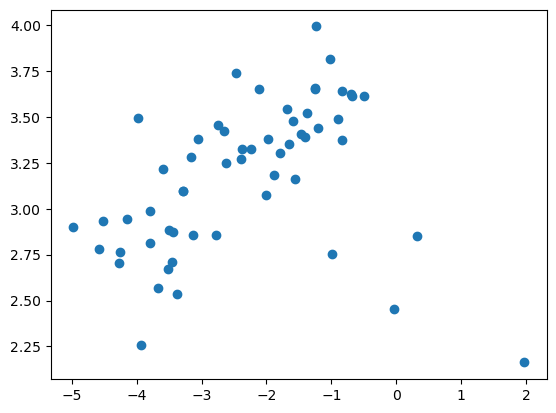

In [19]:
plt.plot(NNphases[:,0], NNphases[:,1],'o')

In [20]:
inf_phases=np.arctan2( NNphases[:,0],NNphases[:,1] )
NNshifted_phi,madNN=optimal_shift(inf_phases, true_phases)
madNN

0.8177855856388492

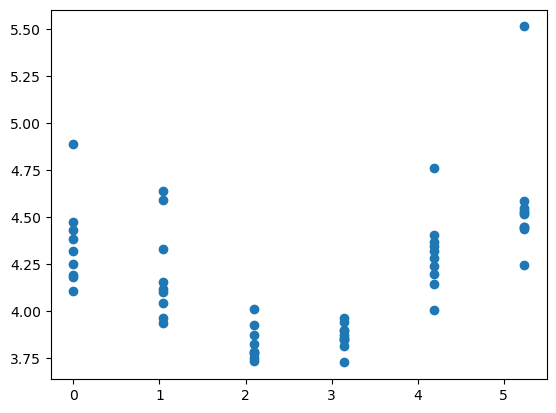

In [21]:
plt.plot(true_phases,NNshifted_phi,'o')

## Adding the "circular" activation function

### Setting the network

In [22]:
#SAME THING BUT USING SEQUENTIAL
'''
class CircularEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(N_Genes, 2,bias=False)
           )
        self.decoder = nn.Sequential(
            nn.Linear(2, N_Genes,bias=False)
           )
    #fucntion that makes the input flow in the network
    def forward(self, x):
        encoded=self.encoder(x) #compress the input
        encoded_circ=encoded/torch.linalg.norm(encoded)
        decoded=self.decoder(encoded_circ)

        return decoded #encoded,encoded_circ 
        '''

'\nclass CircularEncoder(nn.Module):\n    def __init__(self):\n        super().__init__()\n        self.encoder = nn.Sequential(\n            nn.Linear(N_Genes, 2,bias=False)\n           )\n        self.decoder = nn.Sequential(\n            nn.Linear(2, N_Genes,bias=False)\n           )\n    #fucntion that makes the input flow in the network\n    def forward(self, x):\n        encoded=self.encoder(x) #compress the input\n        encoded_circ=encoded/torch.linalg.norm(encoded)\n        decoded=self.decoder(encoded_circ)\n\n        return decoded #encoded,encoded_circ \n        '

In [23]:
class CircularEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Linear(N_Genes, 2,bias=False)
        #self.encoder.weight=nn.Parameter(PCA_tensor)

        self.decoder = nn.Linear(2, N_Genes,bias=False)
        #self.decoder.weight=nn.Parameter(PCA_tensor.transpose(0,1))
    
    #fucntion that makes the input flow in the network
    def forward(self, x):
        encoded=self.encoder(x) #compress the input
        encoded_circ=encoded/torch.linalg.norm(encoded)

        decoded=self.decoder(encoded_circ)

        return decoded #encoded,encoded_circ 

In [24]:
circ_model=CircularEncoder()
criterion2= nn.MSELoss()
optimizer2 = torch.optim.Adam(circ_model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer2 = torch.optim.SGD(circ_model.parameters(),lr=0.001)


In [25]:
#recon= reconstruction of the input
num_epochs=300
outputs=[]

for epoch in range(num_epochs):
  for sample in range(N_Samples):
    input=DATA[:,sample]
    recon=circ_model(input)
    loss=criterion2(recon,input)

    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()
  if (epoch % 10 ==0):
    print("epoch ",epoch,"Loss", loss.item())

epoch  0 Loss 7.248467922210693
epoch  10 Loss 4.677597999572754
epoch  20 Loss 3.1145801544189453
epoch  30 Loss 2.1256327629089355
epoch  40 Loss 1.492301106452942
epoch  50 Loss 1.056587815284729
epoch  60 Loss 0.7397780418395996
epoch  70 Loss 0.5097795724868774
epoch  80 Loss 0.34826627373695374
epoch  90 Loss 0.23955009877681732
epoch  100 Loss 0.16994114220142365
epoch  110 Loss 0.12764661014080048
epoch  120 Loss 0.10307782888412476
epoch  130 Loss 0.08922001719474792
epoch  140 Loss 0.08147433400154114
epoch  150 Loss 0.07704348117113113
epoch  160 Loss 0.07430713623762131
epoch  170 Loss 0.0723879262804985
epoch  180 Loss 0.07086024433374405
epoch  190 Loss 0.06954645365476608
epoch  200 Loss 0.06838499754667282
epoch  210 Loss 0.06735885143280029
epoch  220 Loss 0.06646426767110825
epoch  230 Loss 0.06569858640432358
epoch  240 Loss 0.06505606323480606
epoch  250 Loss 0.06452752649784088
epoch  260 Loss 0.06410225480794907
epoch  270 Loss 0.06376755982637405
epoch  280 Loss 

In [26]:
circ_encoder_base=circ_model.encoder.weight
print(encoder_base)
circ_decoder_baseC=circ_model.decoder.weight
#print(decoder_base)


Parameter containing:
tensor([[-0.2132, -0.1722, -0.1699, -0.0984, -0.2209, -0.1257,  0.0585,  0.2166,
         -0.1076,  0.0379, -0.0410, -0.3193],
        [-0.1389,  0.0430,  0.0938,  0.3204,  0.0245, -0.0033, -0.0704,  0.2715,
          0.1431,  0.1311,  0.3320, -0.2728]], requires_grad=True)


After having the values of the weight, in order to find the values of the neurons, i just reconstruct waht happens to the input until the the bottle neck (encoder linear layer + unit circle projection)

In [27]:
NNphasesC=np.zeros((2,N_Samples))
for sample in range(N_Samples):
  temp=torch.matmul(circ_encoder_base, DATA[:,sample]).detach().numpy()
  NNphasesC[:,sample]=temp
  NNphasesC[:,sample] /= np.linalg.norm(NNphasesC[:,sample])


### Plots

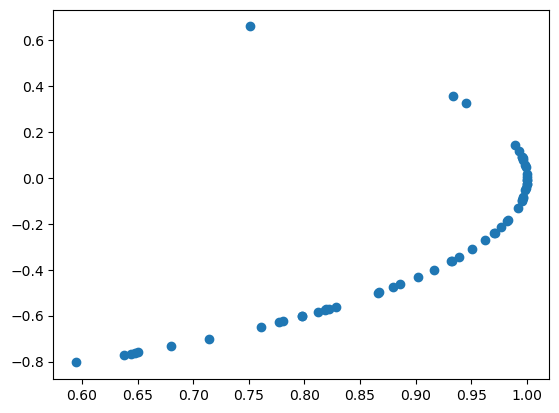

In [28]:
plt.plot(NNphasesC[0,:], NNphasesC[1,:],'o')

In [29]:
inf_phasesC=np.arctan2( NNphasesC[0,:],NNphasesC[1,:] )

NNshifted_phiC,madNNC=optimal_shift(inf_phasesC, true_phases)

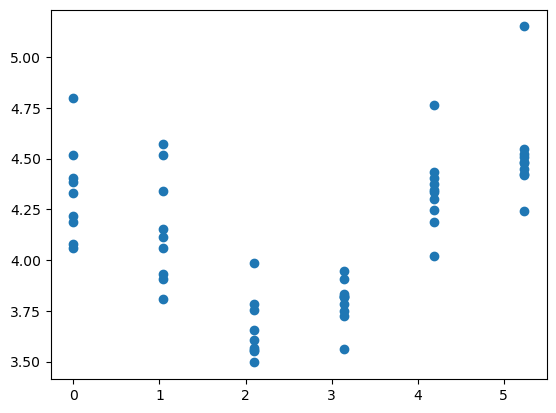

In [30]:
plt.plot(true_phases,NNshifted_phiC,'o')

In [31]:
sum((true_phases-NNshifted_phiC)**2)

289.6699169578554

Outliers really impacat this way of mesuring the goodness of the fit

In [32]:
print('PCA ', sum((true_phases-PCAshifted_phi)**2) )
print('Linear NN ', sum((true_phases-NNshifted_phi)**2) )
print('Circular NN ', sum((true_phases-NNshifted_phiC)**2) )

PCA  248.5143063371627
Linear NN  299.870189517195
Circular NN  289.6699169578554


MAD seems more appropriate


In [33]:
print('PCA ', madPCA )
print('Linear NN ', madNN )
print('circular NN ', madNNC )

PCA  0.33878580216853926
Linear NN  0.8177855856388492
circular NN  0.8146573184354269
